# This is a demonstration notebook for solving inverse AFC plate problem

I will add relevant formulas here later :D

In [1]:
import jax
import jax.numpy as jnp

from jax_plate.Problem import Problem
from jax_plate.Utils import *
from jax_plate.Optimizers import optimize_trust_region, optimize_gd

%matplotlib inline
import matplotlib.pyplot as plt

### Set material parameters

The geometry, location of test point and loading function are defined in `_problem.edp`. I will change it later when we decide on the format of mesh/geometry, comfortable to the experimental guys

In [2]:
# Steel plate for Keldysh guyz
rho = 7920. # [kg/m^3]
E = 198*1e9 # [Pa]
G = 77*1e9
nu = E/(2.*G) - 1.# [1]
h = 1e-3 # [m]
D = E*h**3/(12.*(1. - nu**2))
# this value i don't know
beta = .003 # loss factor, [1]

accelerometer_params = {'radius': 4e-3, 'mass': 0.}

p = Problem("_strip.edp", h, rho, accelerometer_params)
get_afc = p.getAFCFunction(isotropic_to_full)
params = jnp.array([D, nu, beta])

RuntimeError: Resource exhausted: Out of memory while trying to allocate 2667393440 bytes.: while running replica 0 and partition 0 of a replicated computation (other replicas may have failed as well).

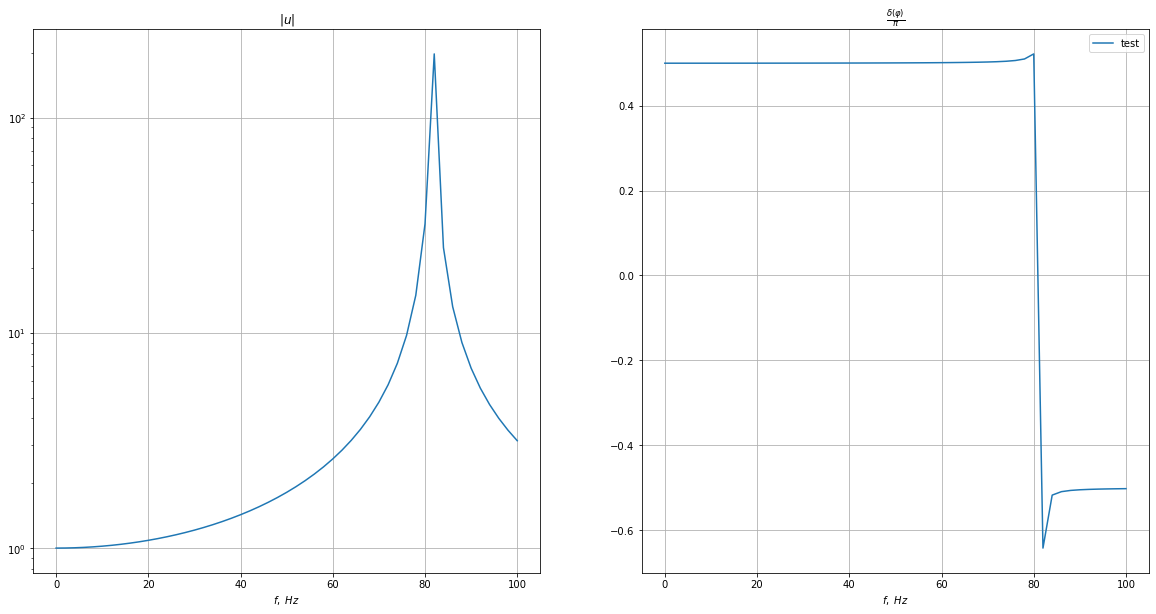

In [3]:
freqs = jnp.linspace(0, 100, 51, endpoint=True)
afc = get_afc(freqs, params)
fig, axs = plot_afc(freqs, afc, label='test')
perturbed_params = params*jnp.array([0.9, 1.1, 1.1])
loss_function = p.getMSELossFunction(isotropic_to_full, freqs, afc)
loss_and_grad = jax.value_and_grad(loss_function)
loss_and_grad(perturbed_params)

For larger grids, only a small number of frequencies can be evaluated at the GPU simultaneously without causing a JAX memory error, so they have to be evaluated in batches. ```batch_size``` parameter has to be chosen experimentally :D 

RuntimeError: Resource exhausted: Out of memory while trying to allocate 39226368 bytes.: while running replica 0 and partition 0 of a replicated computation (other replicas may have failed as well).

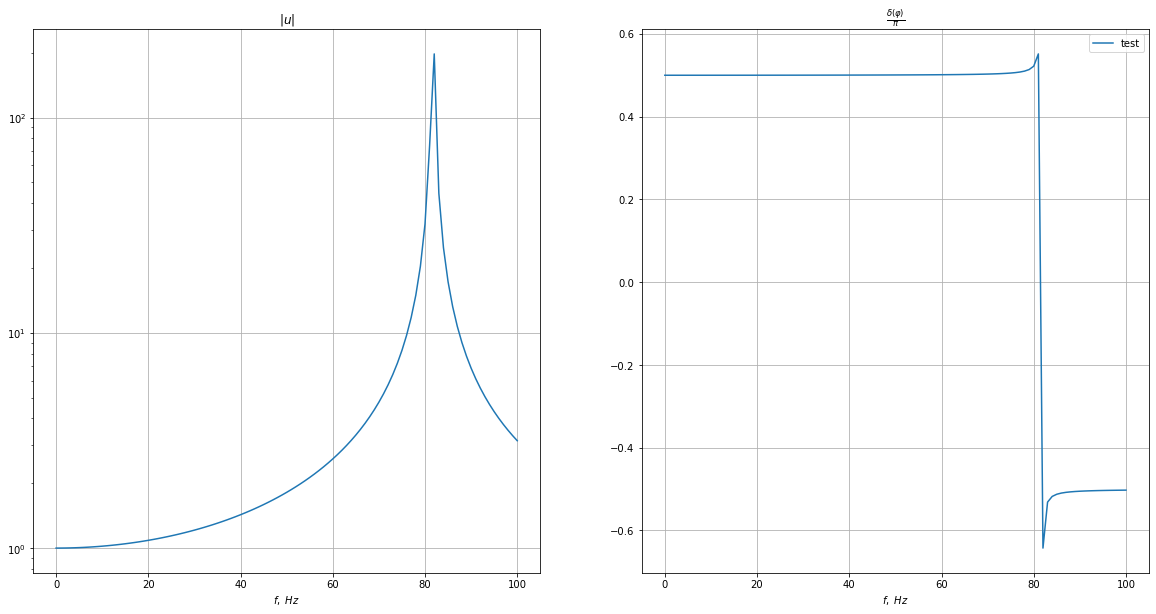

In [3]:
get_afc_batched = p.getAFCFunction(isotropic_to_full, batch_size=30)
freqs = jnp.linspace(0, 100, 101, endpoint=True)
afc = get_afc_batched(freqs, params)
fig, axs = plot_afc(freqs, afc, label='test')
perturbed_params = params*jnp.array([0.9, 1.1, 1.1])
loss_function = p.getMSELossFunction(isotropic_to_full, freqs, afc, batch_size=3)
loss_and_grad = jax.value_and_grad(loss_function)
loss_and_grad(perturbed_params)

## Test local optimization

In [ ]:
loss_function = p.getMSELossFunction(isotropic_to_full, data['frequencies'], data['ref_afc_w_noise'])
opt_result = optimize_trust_region(loss_function, jnp.array(start_params), N_steps=50, delta_max=0.01, )

with np.printoptions(formatter={'float': lambda x: f'{x:.1e}'}):
    print('RE after optimization (RMSE)', (opt_result.x - ref_params)/ref_params)

In [ ]:
param_scaling = lambda x: (x*0.05 + 1.)*start_params
param_transform = lambda x: isotropic_to_full(param_scaling(x))

loss_function = p.getMSELossFunction(param_transform, data['frequencies'], data['ref_afc_w_noise'])
opt_result = optimize_trust_region(loss_function, jnp.array([0.]*3), N_steps=50, delta_max=1., )
with np.printoptions(formatter={'float': lambda x: f'{x:.1e}'}):
    print('RE after optimization (MSE, scaled params)', (param_scaling(opt_result.x) - ref_params)/ref_params)

In [ ]:
loss_function = p.getMSELossFunction(isotropic_to_full, data['frequencies'], data['ref_afc_w_noise'])
#opt_result = optimize_gd(loss_function, jnp.array(start_params), N_steps=30, h=2e-3)
opt_result = optimize_gd(loss_function, opt_result.x, N_steps=15, h=3e-3)

with np.printoptions(formatter={'float': lambda x: f'{x:.1e}'}):
    print('RE after optimization (MSE, GD)', (opt_result.x - ref_params)/ref_params)

In [ ]:
plt.plot(opt_result.f_history)
plt.yscale('log')
plt.grid(True)

In [ ]:
getAFC = p.getAFCFunction(isotropic_to_full)
optimized_afc = getAFC(data['frequencies'], opt_result.x)
#optimized_afc = getAFC(data['frequencies'], param_scaling(opt_result.x))

In [ ]:
fig, axs = plot_afc(data['frequencies'], optimized_afc, label='Optimized', kind='Radial')
#plot_afc(data['frequencies'], data['ref_afc'], label='Reference (no noise)', fig=fig)
#plot_afc(data['frequencies'], data['afc_after_global'], label='Global', fig=fig)
plot_afc(data['frequencies'], data['ref_afc_w_noise'], label='Reference', fig=fig)


In [ ]:
gh = jnp.array(opt_result.grad_history)
gh = jnp.abs(gh)

plt.yscale('log')
labels = ['D', 'nu', 'beta']
for i in range(3):
    plt.plot(gh[:, i], label=labels[i])
plt.legend()
plt.grid()

In [ ]:
xh = jnp.array(opt_result.x_history)

#re_h = jnp.abs((xh - ref_params)/ref_params)
re_h = (xh - ref_params)/ref_params

#plt.yscale('log')
labels = ['D', 'nu', 'beta']
for i in range(3):
    plt.plot(re_h[100:, i], label=labels[i])
plt.legend()
plt.grid()

### Vary the frequency ranges

In [ ]:
def vary_one_parameter(k: int):
    return lambda _p: isotropic_to_full(ref_params.at[k].set(_p))

In [ ]:
fig, axs = plt.subplots(figsize=(30, 10), nrows=1, ncols=3, sharex=True, sharey='col')

ref_params = jnp.array([D, nu, beta])
param_fractions = jnp.linspace((1. - 0.1), (1. + 0.1), 51, endpoint=True)
getAFC = p.getAFCFunction(isotropic_to_full)

frequency_ranges = [(50, 200), (1, 300), (50, 650)]

for jdx, frange in enumerate(frequency_ranges):
    freqs = jnp.linspace(*frange, 200, endpoint=True)
    ref_afc = getAFC(freqs, ref_params)
    for idx, par_name in enumerate(['D', '$\\nu$', '$\\beta$']):
        loss_1d = p.getRMSELossFunction(vary_one_parameter(idx), freqs, ref_afc)
        eval_losses = jax.jit(lambda _ps : [loss_1d(_p) for _p in _ps])
        ref_value = ref_params[idx]
        varied_values = ref_value*param_fractions
        losses = eval_losses(varied_values)
        ax = axs[idx]
        ax.plot(param_fractions + 1e-12, losses, color=f'C{jdx}', label=f'$f \\in [{frange[0]:.1f};\ {frange[1]:.1f}]$')
        #ax.set_yscale('log')
        ax.grid(True)
        if idx == 0:
            ax.set_ylabel("$L(\\theta_i)$")
        if jdx == 0:
            ax.set_title(par_name)
        if jdx == 1:
            ax.set_xlabel('Relative variation')
        if idx == 2:
            ax.legend()
        
        
        
fig.tight_layout()